# Hands-on on Lattice Calculation in Python

*D. Gamba, A. Latina, A. Poyet, G. Sterbini, V. Ziemann*

[Introduction to Accelerator Physics, 18 September 1 October 2022, Kaunas, Lithuania](https://indico.cern.ch/event/1117526/)

<p align="center">
<img src=./_img_exercises/upload_ccbdd4fe3ac855ffa79715fb09caac24.png width="80%">
</p>

## Introduction 

In this document we will present the suggested directions to solve the exercises of the "*Hands-on Lattice Calculations in Python*".
 
These solutions are a natural complement to the ["*Transverse Linear Beam Dynamics Primer using Python*"](./CAS_Optics_Primer.pdf) and will serve as a guidance for the student. Most of the time the result can be achieved using multiple paths and we encourage the student to explore them. 

**In addition, the goal is to stimulate the student's curiosity, so the simple exercise should be challenged to trigger more questions and to dive deeper into the physics of the problem.**

## Is your computer ready?

You received the [instructions](./Setup_Instructions.md) on how to prepare your python working environment.

**QUESTION: is everyone able to launch a jupyter lab server from her/his laptop?** 

**QUESTION: can you import the following packages without errors?** 


In [2]:
# numpy: our main numerical package
import numpy as np
# matplotlib and seaborn: our plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# linear algebra and optimisation algorithms
from numpy.linalg import norm
from scipy.optimize import minimize
# some useful package
from copy import deepcopy

# **Optional:** for animations you might need to configure your jupyter lab properly:
# > pip install ipywidgets
# > jupyter nbextension enable --py widgetsnbextension
# > jupyter labextension install @jupyter-widgets/jupyterlab-manager
from ipywidgets import interactive

### ... some other setup not to be bothered later

Let's also configure `matplotlib` for more presentation-friendly plot production

In [3]:
# some setup for the plotting
from matplotlib import pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## The physics basis

From [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/), you learnt about **matrices** and particle trajectories:

<p align="center">
<img src=./_img_exercises/upload_0c59b4d203ab8bd7b31827ad332baca1.png width="60%">
</p>

Those matrices are the **building blocks** for our  course. Please, keep them in mind.


---

# Let's start with guided exercises

---

### Exercise 1
A `drift` is represented by a matrix with ones on the diagonal and the length of the drift on the upper right corner.
Show, numerically, that multiplying two such matrices, one with $L_1$ and the other with $L_2$ in the upper right corner, produces a matrix with the sum of the distances in the upper right corner.

#### SOLUTION
Even if we can prove it by hand, we take the opportunity to start learning how to use Numpy arrays in Python...

In [4]:
# Let's set our length
L1 = 0.5
L2 = 0.2

# we define the matrices (Numpy arrays)
# NOTA BENE: when defining a numpy 2D array (i.e. a matrix) 
#            the innermost-array represent a row of our matrix
DRIFT_1 = np.array([[1, L1], [0, 1]])
DRIFT_2 = np.array([[1, L2], [0, 1]])

# let's see our matrices:
print(f'DRIFT 1:\n {DRIFT_1}')
print(f'DRIFT 2:\n {DRIFT_2}')

DRIFT 1:
 [[1.  0.5]
 [0.  1. ]]
DRIFT 2:
 [[1.  0.2]
 [0.  1. ]]


In [5]:
# let's multiply the matrices:
print(f'DRIFT 1+2:\n {DRIFT_1*DRIFT_2}')

DRIFT 1+2:
 [[1.  0.1]
 [0.  1. ]]


**QUESTION: what did we expect? is the solution provided by numpy correct?**

In [6]:
(DRIFT_1*DRIFT_2)[0,1] == L1 + L2

False

**BE CAREFUL!** the `*` operator produces **"element-by-element" multiplication**, but here we are looking for a **"matrix multiplication"** operation.
The **`@` operator** is the "multiplication between matrices", introduced in python 3, which you should be using instead.

In [7]:
# => the @ operator is the "multiplication between matrices"
print(f'(correct) DRIFT 1+2:\n {DRIFT_1@DRIFT_2}')
(DRIFT_1@DRIFT_2)[0,1] == L1 + L2

(correct) DRIFT 1+2:
 [[1.  0.7]
 [0.  1. ]]


True

**QUESTION: what is the difference between `DRIFT_2 @ DRIFT_1` and `DRIFT_1 @ DRIFT_2`? Is this important?**


Remember that the *final* coordinates of a particle, $\vec{x_s}$, are given as:

\begin{equation}
\vec{x_s} = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot \vec{x_0}
\end{equation}

where $\vec{x_0}$ are the initial coordinates, $M_1$ is the first element/matrix encountered by the particle, followed by $M_2$ ... $M_n$...

**NEXT: let's repeat the exercise this time for two quadrupoles with different focal length ($f_1$ and $f_2$)**

In [8]:
# additional questions: what if we consider quadrupoles?
f1 = 1
f2 = 2

# we define the matrices
Q_1 = np.array([[1, 0], [-1/f1, 1]])
Q_2 = np.array([[1, 0], [-1/f2, 1]])

# we multiply the matrices. 
# NOTA BENE: the @ operator is the "multiplication between matrix"
Q_2 @ Q_1

array([[ 1. ,  0. ],
       [-1.5,  1. ]])


---

# Interlude: particle coordinates conventions

---

Throughout this course, we define the particle coordinates for a single particle in 1D as:

\begin{equation}
X=\left(
\begin{array}{c}
x \\
p_x
\end{array}
\right),
\end{equation}

while for N particles as:

\begin{equation}
X_N=
\begin{pmatrix}
x_1 & x_2 & ... & x_N\\
p_{x,1} & p_{x,2} & ... & p_{x,N}
\end{pmatrix}
\end{equation}

The generalization to more dimensions is trivial:

\begin{equation}
X_N=
\begin{pmatrix}
x_1 & x_2 & ... & x_N\\
p_{x,1} & p_{x,2} & ... & p_{x,N}\\
y_1 & y_2 & ... & y_N\\
p_{y,1} & p_{y,2} & ... & p_{y,N}
\end{pmatrix}
\end{equation}


Examples:

In [43]:
# Single particle at x=1, px=0
X = np.array([[1], 
              [0]])

# Three particles at x=1 but with different angles
X = np.array([[1,1,1],
              [1,2,3]])

# 10 particles at different positions drawn from a "normal" (Gaussian) 
# distribution of mean 0 and variance 1 and px=0
N = 10
X = np.array([np.random.randn(N), 
              np.zeros(N)])
print(X)

[[ 1.61535385 -0.31431337 -0.28275915 -1.84541235 -1.00890149  2.05519054
   0.6842666   1.97829172 -0.94255711 -1.21343414]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]


### Exercise 2
How do you describe a ray that is parallel to the optical axis?

#### SOLUTION
The phase space vector of a particle parallel ot the optical axis can be represented (1D) by 
\begin{equation}
X=\left(
\begin{array}{c}
x \\
0
\end{array}
\right),
\end{equation}
this means that is $x'$ is vanishing.

In [9]:
# in Python
x = 0.5 # initial position
X = np.array([[x], 
              [0]])
print(f'Initial particle coordinates:\n {X}')

Initial particle coordinates:
 [[0.5]
 [0. ]]


### Exercise 3
How do you describe a ray that is on the optical axis?

#### SOLUTION
The phase space vector of a particle sitting on the optical axis can be represented by 
\begin{equation}
X=\left(
\begin{array}{c}
0 \\
x'
\end{array}
\right).
\end{equation}
this means that $x$ is vanishing.

In [10]:
# in Python
px = 0.3 # initial angle
X = np.array([[0], 
              [px]])
print(f'Initial particle coordinates:\n {X}')

Initial particle coordinates:
 [[0. ]
 [0.3]]


### Exercise 4
Show by multiplying the respective matrices that a parallel ray, which first passes through a lens with focal length $f$ and then moves on a straight line, actually crosses the optical axis at a distance $L=f$ downstream of the lens. 

**Hint 1**: recall from [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/upload_938d56be287cccab0bd618456f94efc1.png width="60%">
</p>

**Hint 2**: think a little extra about ordering of the matrices.



#### SOLUTION

In [11]:
# Let's define a quadrupole with focal length f1
f1 = 1
Q = np.array([[1, 0], [-1/f1, 1]])

# Let's define a drift of length f1
DRIFT = np.array([[1, f1], [0, 1]])

# And our inital vector (parallel ray)
x = 0.5 # initial position
X = np.array([[x], 
              [0]])

# And we propagate, as in Ex. 2
DRIFT @ Q @ X

array([[ 0. ],
       [-0.5]])

The particle is indeed on the beam axis (see Exercise 3).

**QUESTION: is this valid for whatever initial offset? Try to plot the finial $x_s$ as a function of several initial $x_0$**

Text(0, 0.5, 'Final x position')

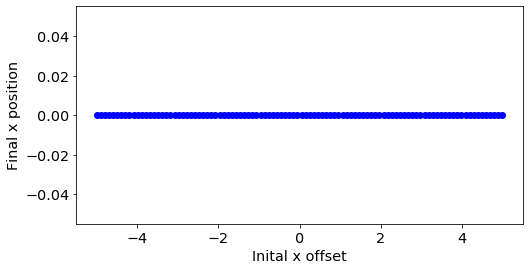

In [12]:
# Let's define a list of several initial offset
x_init = np.linspace(-5, 5, 100) # creates an array of 100 points, linearly spaced form 05 to 5 
x_result = [] # we initiate an empty list to store our final results

for xx in x_init:
    X = np.array([[xx], 
                  [0]]) # we redefine our initial vector
    X_fin = DRIFT @ Q @ X # we compute the final coordinates 
    x_result.append(X_fin[0]) # we populate our result list with the x coordinate
    
# And let's plot the final x position as a function of the initial one
plt.figure(figsize=(8,4))
plt.plot(x_init, x_result, 'b-o', lw=2)
plt.xlabel("Inital x offset")
plt.ylabel("Final x position")

We see that no matter the inital offset, the particle is always on the beam axis. **This is the meaning of the focal length!**

---

# Interlude: a small tracking library

---


## Some more convenient functions to model an accelerator

We are going to define some important functions, very useful for the rest of the exercises.

### Modeling of a drift

Let's start with a function that generate a convenient representation of a **drift**. 

In [13]:
def D(L):
    '''Returns the list of a L-long drift'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 
    return [{'matrix':np.array([[1, L],[0, 1]]), 'length':L}] 

# A drift of L=2 m can be generated as:
D(2)

[{'matrix': array([[1, 2],
         [0, 1]]),
  'length': 2}]

The main reason for returning such a `list` with inside a `dictionary` are:

- it will allow us to keep track of the path travelled by the particle (thanks to the `length` dictionary key)
- the element is embedded in a list so to allow for an easy concatenation of elements (e.g. D(1.2) + D(4.3) will produce a list with two elements: one representing a drift of L=1.2 and one of L=4.3 m.

You can find more details about this choice on our ["*Transverse Linear Beam Dynamics Primer using Python*"](./CAS_Optics_Primer.pdf)

In [14]:
# e.g. representation of a beamline made of two drifts of different length:
D(1) + D(2)

[{'matrix': array([[1, 1],
         [0, 1]]),
  'length': 1},
 {'matrix': array([[1, 2],
         [0, 1]]),
  'length': 2}]

> **Note:** this is just **one of many possible implementation** choices.
> One could think of different structures and ways to model a beamline.
> The scope of this course is not to give you a high-efficency and optimised tracking code, 
> but to **help you to understand** the basics of the underlying **accelerator physics**.

### Modeling of a quadrupole

In [15]:
def Q(f):
    '''Returns the list of a quadrupole with focal length f'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 
    return [{'matrix':np.array([[1, 0],[-1/f, 1]]), 'length':0}]

# e.g. representation of a beamline made of one drift followed by one quadrupole:
D(1) + Q(2)

[{'matrix': array([[1, 1],
         [0, 1]]),
  'length': 1},
 {'matrix': array([[ 1. ,  0. ],
         [-0.5,  1. ]]),
  'length': 0}]

### From a list of elements - or beamline - to an equivalent single element

Given our choice of beamline strcuture, i.e. a `list` of **elements**, each modeled by a `dictionary` with some properties, we can define a useful function to compute the *equivalent* matrix (actually an *equivalent* **element** represented by a `dictionary`) of a whole beamline made of several **elements**:

In [16]:
def getEquivalentElement(beamline):
    '''Returns the equivalent single element of a beamline'''
    # we start from an identity matrix (np.eye)
    # with the same dimension of the matrix of the
    # first element of the beamline
    equivalentElement = np.eye(beamline[0]['matrix'].shape[0])
    length = 0
    # NB: we reverse the order of the beamline ([-1::-1])
    for elements in beamline[-1::-1]:
        # we multiply the matrices 
        equivalentElement = equivalentElement @ elements['matrix']
        # and we add the lengths
        length = length + elements['length']
    # we return the dict with the "usual" keys (matrix and length)
    # as for the definition of the D and Q functions
    return [{'matrix':equivalentElement, 'length':length}]

# e.g. equivalent representation of a beamline made of two drifts of different length:
getEquivalentElement(D(1) + D(2))

[{'matrix': array([[1., 3.],
         [0., 1.]]),
  'length': 3}]

### Tracking particles along a beamline

We can also write a function that "tracks" one, or several particles defined by their initial coordinate, along a beamline:

In [17]:
def transportParticles(x0,beamline,s0=0):
    '''Track the particle(s) x0 along the given beamline. 
    If needed, one can specify an initial longitudinal position s0, otherwise set to 0.
    '''
    coords = [x0]
    s = [s0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1])
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    return {'x':  coords[:,0,:], # [particle_idx, s_idx]
            'px': coords[:,1,:], # [particle_idx, s_idx]
            's':  np.array(s), # [s_idx]
            'coords': coords,} # [particle_idx, coord_idx, s_idx]

# e.g. define the intial coordinates for 3 particles all with
#      0 x position, but different angles:
x_0 = np.array([[0,0,0,0],
                [0,1,2,4]])
# and let's transport them throw a lattice made of 2 equally long drifts
#   and see the final x coordinate
transportParticles(x_0, D(1)+D(1))['x'][:, -1]

array([0, 2, 4, 8])

### Exercise 5
Let's consider the beamline from [Exercise 4](#exercise-4), i.e. a quadrupole followed by a drift. Let's set the quadrupole's $f=3$ and again verify that parallel rays cross the axis after a distance $L=f$, but this time **using our newly developed functions**.

Please, make one or more plots to prove it using several particles, i.e. different initial conditions. 

#### SOLUTION 1 - using `getEquivalentElement` function.

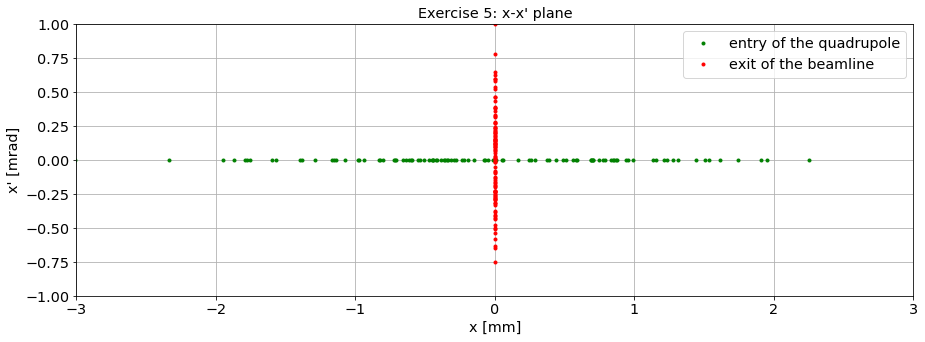

In [32]:
# Particle definition
N = 100
X = np.array([np.random.randn(N)/1000, 
              np.zeros(N)])
# beamline definition
myF = 3 # [m]
beamline = + 2 * D(myF/10) + Q(myF) + 10 * D(myF/10)
output = getEquivalentElement(beamline)[0]['matrix'] @ X
# plotting
plt.plot(X[0,:]*1e3, X[1,:]*1e3,'.g', label='entry of the quadrupole');
plt.plot(output[0,:]*1e3, output[1,:]*1e3,'.r', label='exit of the beamline');
plt.legend()
plt.grid(True)
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.xlim([-3,3])
plt.ylim([-1,1])
plt.title("Exercise 5: x-x' plane");

#### SOLUTION 2 - using `transportParticles` function.

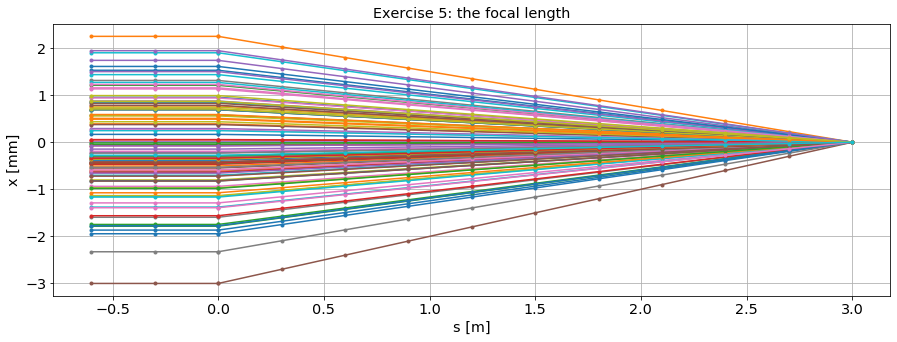

In [33]:
# we the transportParticles function we can se the particle along the line
# this can help to visualize the concept of focal length
output = transportParticles(X, beamline, s0=-2*myF/10)
for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3,'.-')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.title('Exercise 5: the focal length')
plt.grid(True)

Indeed we found back the expected results.

---

# Now is your turn!

Continue by yourself with the exercises of:

- "02_Single_Particle_Beamline.ipynb" 
- "03_Multi_Particles_Beamline.ipynb"
- "04_Periodic_Systems.ipynb"
- "05_Advanced_Exercises.ipynb"

The library of functions introduced in this and the next notebooks are all gathered in the "tracking_library.py" file and can imported as:

```
from tracking_library import *
```


---